In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.models as models
from torchvision.models.efficientnet import _efficientnet_conf, _efficientnet
from functools import partial
import random, os
import itertools
from astropy.stats import sigma_clip
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

## Metric

In [2]:
class ParticipantVisibleError(Exception):
    pass
def ariel_score(
        solution,
        submission,
        naive_mean,
        naive_sigma,
        sigma_true
    ):
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    if submission.min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')

    n_wavelengths = 283

    y_pred = submission[:, :n_wavelengths]
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission[:, n_wavelengths:], a_min=10**-15, a_max=None)
    y_true = solution

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    #print(GLL_pred, GLL_true, GLL_mean)
    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return submit_score #float(np.clip(submit_score, 0.0, 1.0))

## Raw data binned 15 time measurements

Unfortunately, I have lost the exact code that I received the dataset with, I really hope that it matches the one in the inference notebook.

In [3]:
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv',
                           index_col='planet_id')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')
# train_AIRS = np.load('/kaggle/input/adc-preprocced-signal-data/train_AIRS_preproc.csv.npy')
# train_FGS = np.load('/kaggle/input/adc-preprocced-signal-data/train_FGS1_preproc.csv.npy')
# pre_train = np.concatenate([train_FGS, train_AIRS], axis=2)
pre_train = np.load('/kaggle/input/preproceesed-data-375/pre_train_375.npy')
pre_test = np.load('/kaggle/input/preproceesed-data-375/pre_test_375.npy')
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [4]:
pre_train.shape

(673, 375, 283)

## Transit phase detector

A simple algorithm for finding points where there is a rapid drop in luminosity

## Dataset
We will use (flux - flux_transit) / flux_star as features. If we didn't have a distortion of the star's light, then our targets would be exactly among these signs.

In [5]:
def phase_detector(signal):
    phase1, phase2 = None, None
    best_drop = 0
    for i in range(50,150):        
        t1 = signal[i:i+20].max() - signal[i:i+20].min()
        if t1 > best_drop:
            phase1 = i+20+5
            best_drop = t1
    
    best_drop = 0
    for i in range(200,300):
        t1 = signal[i:i+20].max() - signal[i:i+20].min()
        if t1 > best_drop:
            phase2 = i-5
            best_drop = t1
    
    return phase1, phase2

In [6]:
train = pre_train.copy()
for i in range(len(train_adc_info)):
    p1,p2 = phase_detector(pre_train[i,:,1:].mean(axis=1))
    train[i] = (train[i] - pre_train[i,p1:p2].mean(axis=0)) / pre_train[i,list(range(p1-40)) + list(range(p2+40,375))].mean(axis=0) * 1000.0

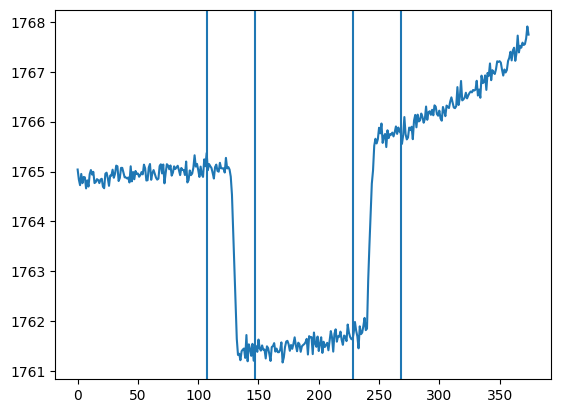

In [7]:
n = 205
plt.plot(pre_train[n,:,1:].mean(axis=1))
p1, p2 = phase_detector(pre_train[n,:,1:].mean(axis=1))
plt.axvline(p1)
plt.axvline(p2)
plt.axvline(p1-40)
plt.axvline(p2+40)

In [8]:
train.mean(), train.std()

(1.6391348407613593, 2.8748483317598192)

## Model 
As a model, I use MobileNet_v2 as the least overfitting. Initially, it accepts a 3-channel image as input, so I added a layer that converts the input into a three-channel one.

The output has 3 numbers for each wavelength corresponding to 0.1587,0.5,0.8413 percentiles.

In [9]:
def create_model_mnet2():
    model = models.mobilenet_v3_small(dropout=0.0, norm_layer = nn.Identity) # batch norm을 모두 indentity 하게 바꿔버림-> batch norm에서 수행하는 바이어스 보정이 사라짐->bias=True로 바꿀 필요성 생김
    model.features[0][0] = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)# 모델 가중치 초기화를 위해 bias=False로 설정해서 레이어 재설정한건가? 왜 bias = False로 한지 모르겟음
    model.classifier[3] = nn.Linear(in_features=1024, out_features=283*3, bias=True) # 최종 output 283 * 3
    return model

class ImpModel(torch.nn.Module):
    def __init__(self):
        super(ImpModel, self).__init__()

        self.filter = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=(3,1), stride = (2,1), bias=False),
            nn.LeakyReLU()
        )
        self.model_1d = create_model_mnet2()
        
    def forward(self, x):
        x = self.filter(x)
        x = self.model_1d(x)
        return x

## Loss
This loss function predicts not only the value itself, but also its two percentiles. With their help, assuming that the error is distributed normally, we can get an estimate of the standard deviation.

https://www.kaggle.com/code/vyacheslavefimov/quantile-loss-quantile-regression

quantile을 설정해 과대예측, 과소예측 경향성을 예측 모델에 추가하여 uncertainty를 좀 더 정확하게 예측하고자 하기 위함인듯

In [ ]:
def q_loss(quantiles, y_pred, target):
    losses = []
    for i, q in enumerate(quantiles):        
        errors = target - y_pred[..., i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(-1))#
    losses = 2 * torch.cat(losses, dim=2)

    return losses


In [11]:
# train_sample = train.copy()
# planet_data = train_sample[0].reshape(1,375,283)
# planet_target = train_labels.loc[785834].values
# test_tensor, planet_target = torch.tensor(planet_data, dtype=torch.float32).unsqueeze(1), torch.tensor(planet_target, dtype=torch.float32).unsqueeze(1)  
# test_tensor, planet_target = test_tensor.to(device), planet_target.to(device)
# with torch.no_grad(): 
#     model.eval()
#     pred = model(test_tensor)
# output_a = pred[:,1::3] # differ to quantile 0, 1, 2

In [12]:
# a=q_loss([0.1587, 0.5, 0.8413], pred, planet_target)
# a.shape

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
X = list(range(len(train)))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

oof_pred = np.zeros_like(train_labels.values)
oof_sigmas = np.zeros_like(train_labels.values)

for ifold, (train_index, test_index) in enumerate(kf.split(X)):
   
    train_x = torch.from_numpy(train[train_index]).unsqueeze(1).float().to(device)
    train_y = torch.from_numpy(train_labels.values[train_index]).float().to(device)
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

    val_x = torch.from_numpy(train[test_index]).unsqueeze(1).float().to(device)
    val_y = torch.from_numpy(train_labels.values[test_index]).float().to(device)
    val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    model = ImpModel().to(device)

    best_metric = 0
    total_train_losses = []

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200, eta_min=0, last_epoch=-1)
    for epoch in range(200):
        ep_losses = []        
        model.train()
        for i, data in enumerate(training_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            
            optimizer.zero_grad()

            # augmentations: disturb channel and reverse the time
            if epoch > 0:
                for j in range(inputs.shape[-1]):
                    if np.random.random() > 0.8:
                        inputs[...,j] = inputs[...,j] * (1 + np.random.randn() * 0.01)
                for k in range(inputs.shape[0]):
                    if np.random.random() > 0.8:
                        inputs[k] = torch.flip(inputs[k], (1,))

            outputs = model(inputs).reshape((inputs.shape[0], 283, 3))

            loss = q_loss([0.1587, 0.5, 0.8413], outputs, labels).mean()
            loss.backward()

            optimizer.step()

            ep_losses.append(loss.item())

        avg_loss = np.mean(ep_losses)
        total_train_losses.append(avg_loss)

        model.eval()
        running_vloss = 0
        preds = np.zeros((len(val_dataset), 283))
        sigmas = np.zeros((len(val_dataset), 283))
        v_offset = 0
        with torch.no_grad():        
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device) 
                
                voutputs = model(vinputs).reshape((vinputs.shape[0], 283, 3))
                preds[v_offset:v_offset+len(vinputs)] = voutputs[:, :, 1].detach().cpu().numpy()
                sigmas[v_offset:v_offset+len(vinputs)] = voutputs[:, :, 2].detach().cpu().numpy() - voutputs[:, :, 0].detach().cpu().numpy()
                vloss = q_loss([0.1587, 0.5, 0.8413], voutputs, vlabels).mean()
                running_vloss += vloss
                v_offset += len(vinputs)

        avg_vloss = running_vloss / (i + 1)

        metric = ariel_score(
            train_labels.values[test_index],
            np.concatenate([preds.clip(0), sigmas.clip(0)], axis=1), 
            train_labels.values[test_index].mean(),
            train_labels.values[test_index].std(),
            sigma_true=1e-5
        )
        
        print('fold {} epoch {} train {} valid {} metric {}'.format(
            ifold, epoch, round(avg_loss*100, 3), round(avg_vloss.item()*100, 3), round(metric, 3)
        ))
        
        scheduler.step()
        
    oof_pred[test_index] = preds
    oof_sigmas[test_index] = sigmas
    torch.save(model.state_dict(), 'purple_hat_{}'.format(ifold))


fold 0 epoch 0 train 0.363 valid 0.112 metric -0.119
fold 0 epoch 1 train 0.11 valid 0.095 metric -0.081
fold 0 epoch 2 train 0.104 valid 0.097 metric -0.069
fold 0 epoch 3 train 0.107 valid 0.094 metric -0.057
fold 0 epoch 4 train 0.104 valid 0.095 metric -0.105
fold 0 epoch 5 train 0.102 valid 0.094 metric -0.088
fold 0 epoch 6 train 0.104 valid 0.097 metric -0.112
fold 0 epoch 7 train 0.104 valid 0.1 metric -0.087
fold 0 epoch 8 train 0.104 valid 0.094 metric -0.092
fold 0 epoch 9 train 0.104 valid 0.093 metric -0.048
fold 0 epoch 10 train 0.104 valid 0.095 metric -0.073
fold 0 epoch 11 train 0.105 valid 0.101 metric -0.092
fold 0 epoch 12 train 0.103 valid 0.094 metric -0.099
fold 0 epoch 13 train 0.104 valid 0.103 metric -0.095
fold 0 epoch 14 train 0.104 valid 0.057 metric -6.644760228195513e+20
fold 0 epoch 15 train 0.048 valid 0.047 metric -2.5502937273433897e+21
fold 0 epoch 16 train 0.036 valid 0.029 metric -5.601919548192701e+19
fold 0 epoch 17 train 0.037 valid 0.028 metric

In [16]:
ariel_score(        
            train_labels.values,
            np.concatenate([oof_pred.clip(0), oof_sigmas.clip(0)], axis=1), 
            train_labels.values.mean(),
            train_labels.values.std(),
            sigma_true=1e-5)

0.4022801974296382

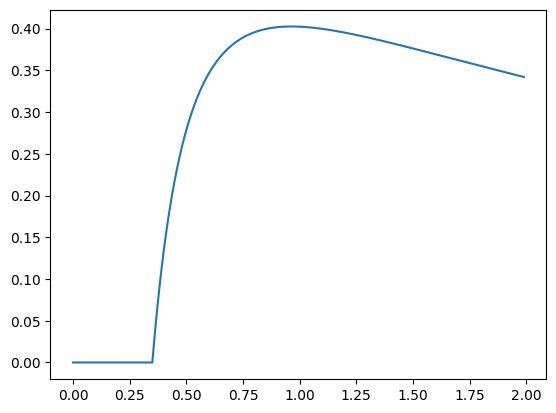

In [17]:
xs,ys = [], []
for i in range(200):
    xs.append(i/100.0)
    ys.append(ariel_score(        
            train_labels.values,
            np.concatenate([oof_pred.clip(0), oof_sigmas.clip(0) * (i / 100.0)], axis=1), 
            train_labels.values.mean(),
            train_labels.values.std(),
            sigma_true=1e-5))
plt.plot(xs, np.array(ys).clip(0))

In [18]:
np.save('purple_hat_oof_pred.npy', oof_pred)
np.save('purple_hat_oof_sigmas.npy', oof_sigmas)

## Inteference

In [19]:
test = pre_test.copy()
for i in range(len(pre_test)):
    p1,p2 = phase_detector(pre_test[i,:,1:].mean(axis=1))
    test[i] = (test[i] - pre_test[i,p1:p2].mean(axis=0)) / pre_test[i,list(range(p1-20)) + list(range(p2+20,187))].mean(axis=0) * 1000.0
test_tensor = torch.tensor(test, dtype=torch.float32).unsqueeze(1) 
test_tensor = test_tensor.to(device)
with torch.no_grad(): 
    model.eval()
    pred = model(test_tensor)
output_a = pred[:,1::3] # differ to quantile 0, 1, 2

In [20]:
output_numpy = output_a.cpu().detach().numpy()

In [21]:
sample_sub = pd.read_csv("/kaggle/input/ariel-data-challenge-2024/sample_submission.csv")
sub = sample_sub.copy()
sub.iloc[:,1:284] = output_numpy

## Sigma

In [ ]:
# model.eval()
# running_vloss = 0
# preds = np.zeros((1, 283))
# sigmas = np.zeros((1, 283))
# v_offset = 0
# with torch.no_grad():        
#     vinputs= test_tensor
#     vinputs= vinputs.to(device) 

#     voutputs = model(vinputs).reshape((vinputs.shape[0], 283, 3))
#     preds[v_offset:v_offset+len(vinputs)] = voutputs[:, :, 1].detach().cpu().numpy()
#     sigmas[v_offset:v_offset+len(vinputs)] = voutputs[:, :, 2].detach().cpu().numpy() - voutputs[:, :, 0].detach().cpu().numpy()

In [23]:
sub.iloc[:,284:] = 0.00025252799786631074
sub.to_csv("submission.csv", index = False)

In [24]:
sub

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,499191466,0.002706,0.00273,0.002726,0.002724,0.002726,0.002719,0.00272,0.002723,0.002722,...,0.000253,0.000253,0.000253,0.000253,0.000253,0.000253,0.000253,0.000253,0.000253,0.000253
